In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pystan
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import scipy as sp
import matplotlib.pyplot as plt

az.style.use('arviz-darkgrid')

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Medium

## 13M1

Taken from PyMC3 dev's Chp_13 notebook:

In [6]:
a = 3.5        
b = -1.        
sigma_a = 1.   
sigma_b = 0.5  
rho = 0

Mu = [a, b]
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]]) #Sigma covariance matrix

# simulate observations
N_cafes = 20
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

N_visits = 10
afternoon = np.tile([0,1], N_visits * N_cafes//2)
cafe_id = np.repeat(np.arange(N_cafes), N_visits)

mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5 # std dev within cafes
wait = np.random.normal(loc=mu, scale=sigma, size=N_visits*N_cafes)

# Create dataframe
d = pd.DataFrame(dict(cafe=cafe_id , afternoon=afternoon , wait=wait))
d.cafe = d.cafe +1
d.head(11)

,cafe,afternoon,wait
0,1,0,2.819744
1,1,1,2.587915
2,1,0,3.471372
3,1,1,3.373449
4,1,0,4.017161
5,1,1,2.100450
6,1,0,2.829624
7,1,1,2.419580
8,1,0,2.618352
9,1,1,2.280893


I've annoted the code from [ssp3nc3r's notebook (stan output.var="m13_1")](https://github.com/ssp3nc3r/rethinking/blob/master/chapter13.Rmd)

In [3]:
m_13_m1 = '''
data {
  int N;
  int N_cafe;
  int cafe_id[N];
  real W[N];
  int A[N];
}
parameters {
  real a;
  real b;
  vector[N_cafe] a_cafe;
  vector[N_cafe] b_cafe;
  real<lower=0> sigma; // Likelihood std
  vector<lower=0>[2] sigma_cafe;
  corr_matrix[2] Rho;
}
transformed parameters {
  vector[2] Mu_ab = [a, b]'; // Vector of grand means of varying effects
  vector[2] v_a_cafeb_cafe[N_cafe]; // Vector of adaptive priors for alpha and beta
  cov_matrix[2] SRS_sigma_cafeRho; // Covariance matrix
  for ( j in 1:N_cafe ) v_a_cafeb_cafe[j,1:2] = [a_cafe[j], b_cafe[j]]'; // Fill adaptive priors matrix with the adaptive parameters
  SRS_sigma_cafeRho = quad_form_diag(Rho,sigma_cafe); // See note below
}
model {
  vector[N] mu;
  
  //priors
  // Adaptive priors are learned from the data, so not specified here
  target += normal_lpdf(a | 0, 10);
  target += normal_lpdf(b | 0, 10);
  target += cauchy_lpdf(sigma | 0 , 2 );
  target += cauchy_lpdf(sigma_cafe | 0 , 2 );
  target += lkj_corr_lpdf(Rho | 2 );
  
  // linear model  
  for(i in 1:N) mu[i] = a_cafe[cafe_id[i]] + b_cafe[cafe_id[i]] * A[i];
  
  target += normal_lpdf(W | mu, sigma);
  target += multi_normal_lpdf(v_a_cafeb_cafe | Mu_ab , SRS_sigma_cafeRho );
}
generated quantities {
  vector[N] log_lik;
  {
  vector[N] mu;
  for(i in 1:N) {
    mu[i] = a_cafe[cafe_id[i]] + b_cafe[cafe_id[i]] * A[i];
    log_lik[i] = normal_lpdf(W[i] | mu[i], sigma);
  }
  }
}
'''

From the stan user guide: The function quad_form_diag is defined so that quad_form_diag(Sigma, tau) is equivalent to diag_matrix(tau) * Sigma * diag_matrix(tau)

In [4]:
m13_m1 = pystan.StanModel(model_code=m_13_m1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_353917076345c4da34dcdab984c61c4a NOW.


In [9]:
df = dict(N = len(d),
          N_cafe = max(d['cafe']),
          cafe_id = d['cafe'],
          W = d['wait'],
          A = d['afternoon'])

fit_m13_m1 = m13_m1.sampling(data = df)

In [10]:
samples_m13_m1 = az.from_pystan(posterior=fit_m13_m1)

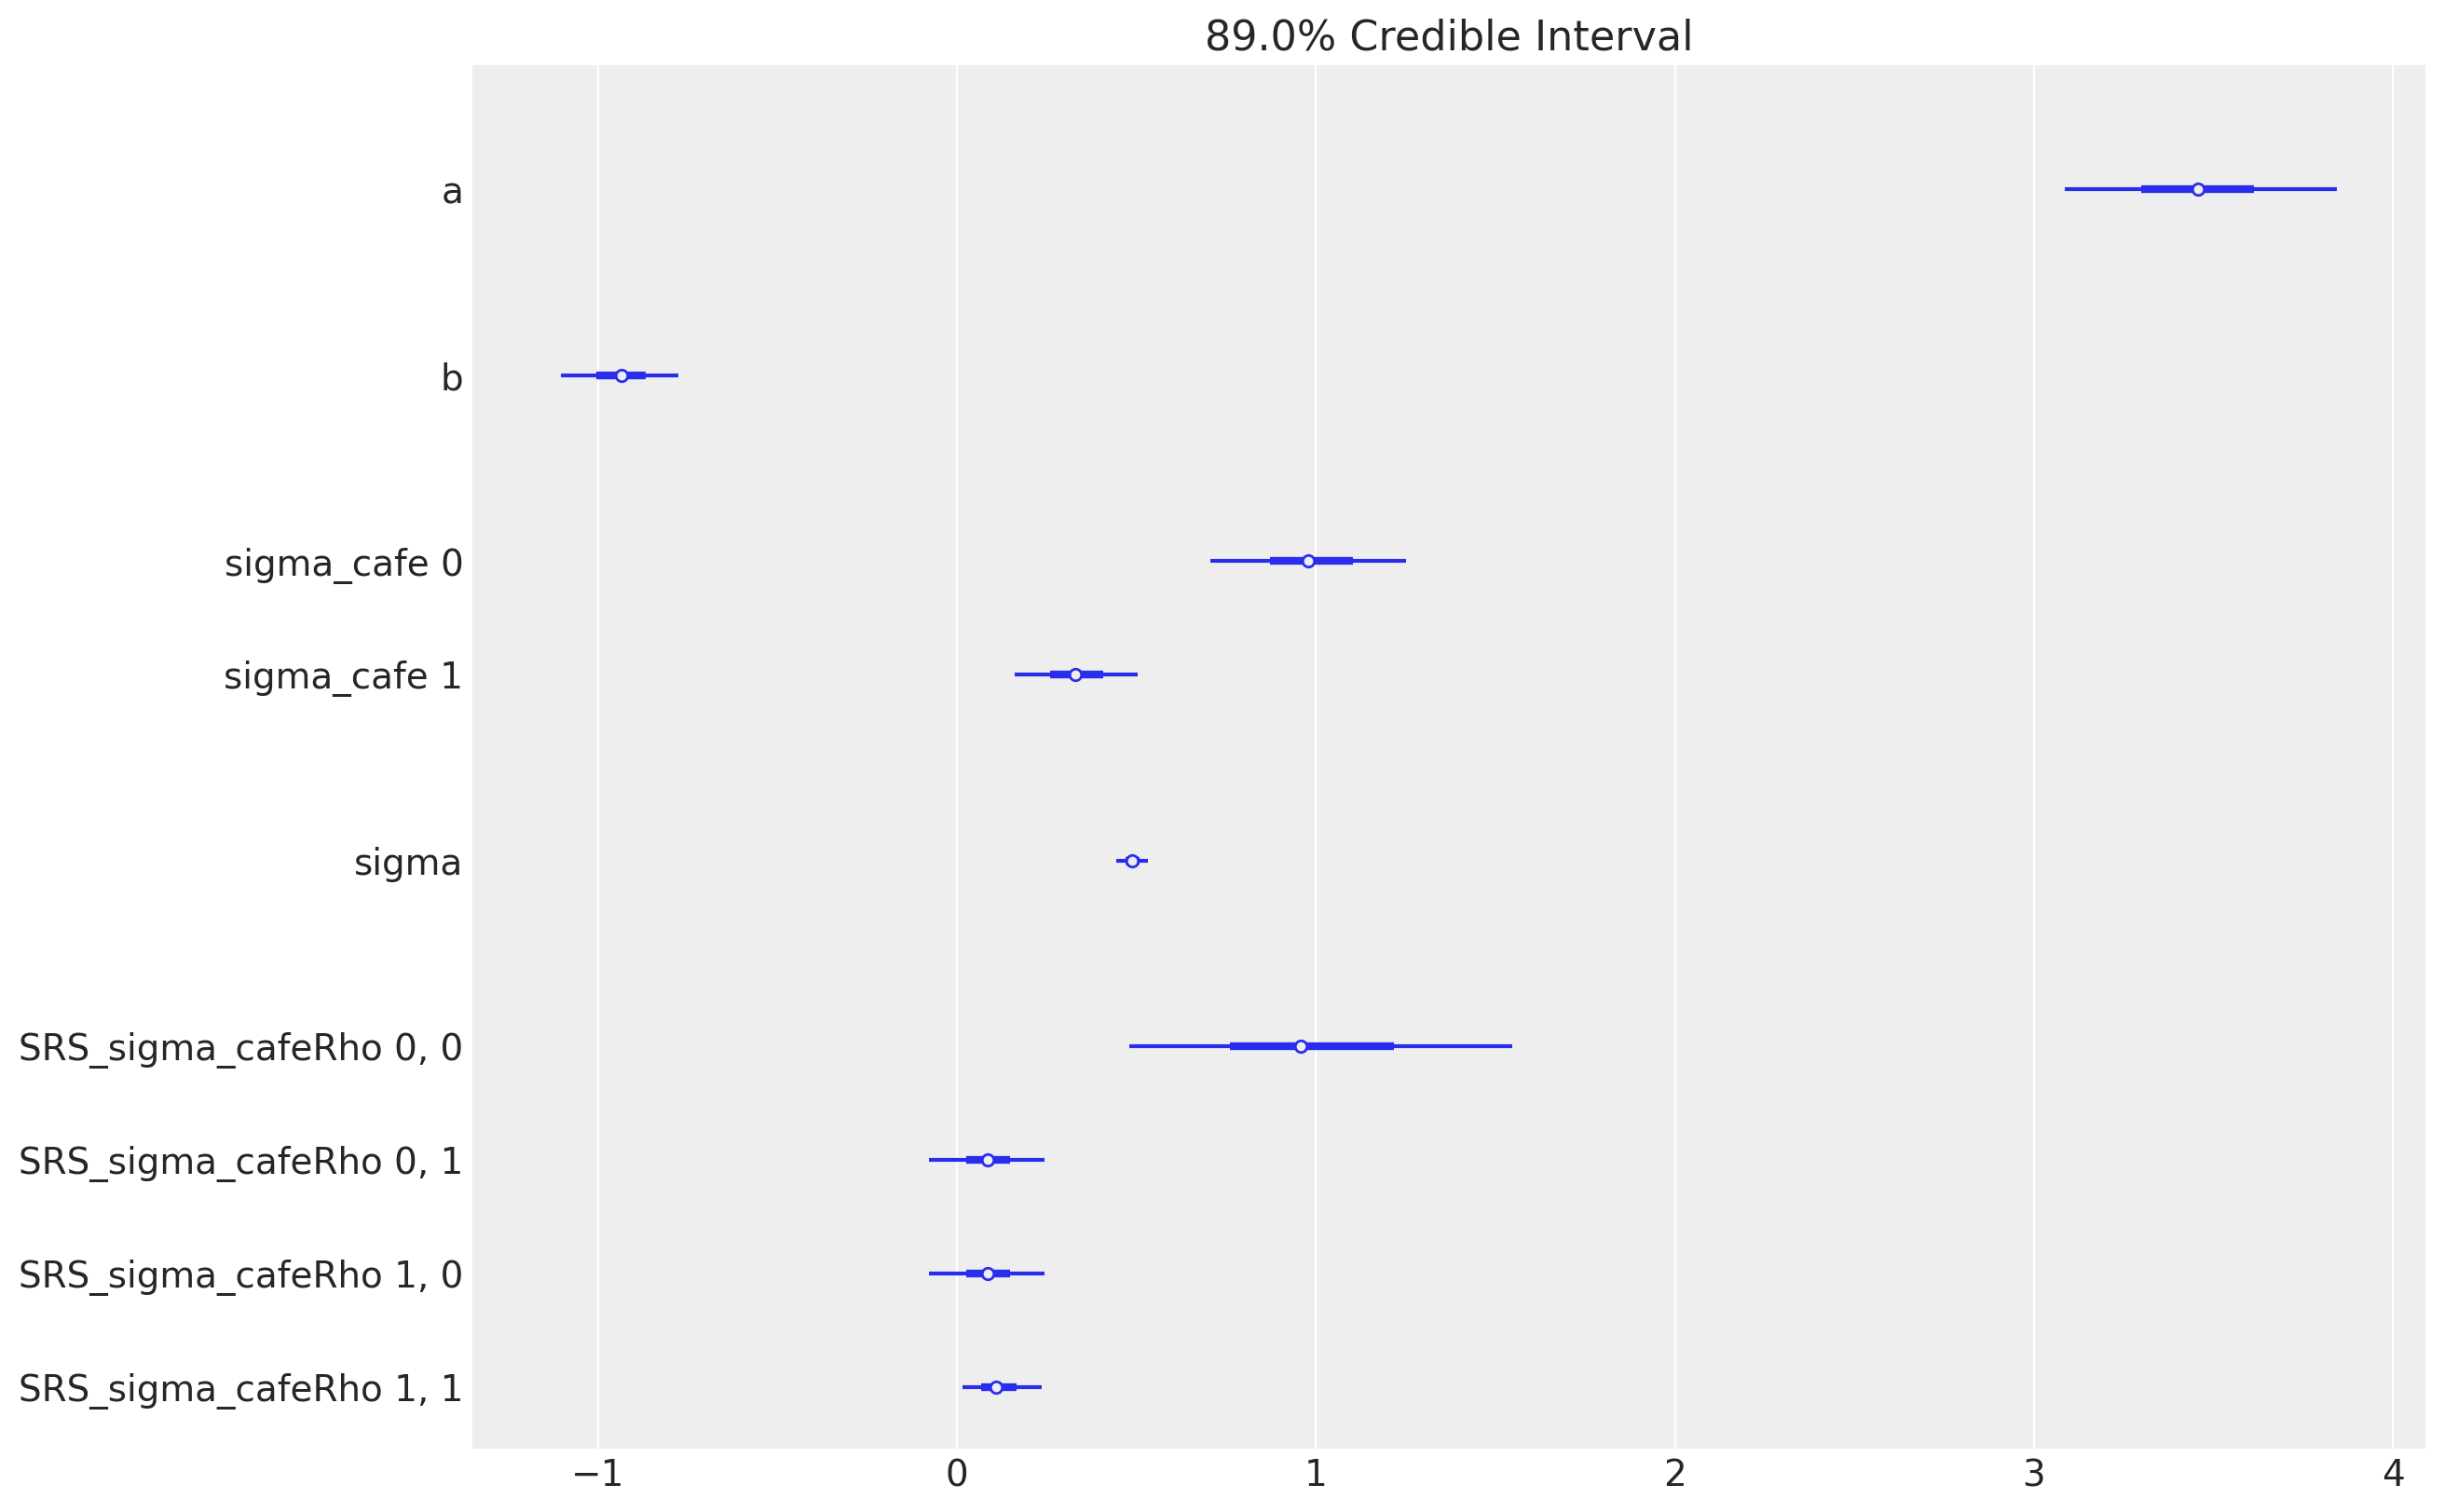

In [20]:
az.plot_forest([samples_m13_m1], 
               var_names = ['a', 'b', 'sigma_cafe', 'sigma', 'SRS_sigma_cafeRho'],
               credible_interval=0.89, 
               figsize=(13,8), 
               combined=True);

sigma_cafe 0 ($\sigma_{\alpha}$)\
sigma_cafe 1 ($\sigma_{\beta}$)

SRS_sigma_cafeRho 0,0 ($\sigma_{\alpha}^2$)\
SRS_sigma_cafeRho 1,1 ($\sigma_{\beta}^2$)\
SRS_sigma_cafeRho 0,1; 1,0 ($\sigma_{\alpha}\sigma_{\beta}\rho$)

## 13M3

In [28]:
# From code chunk 13.17
d_ad = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/UCBadmit.csv', 
                    sep=';')
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

Dept_id = d_ad['dept_id'].values+1
Ndept = len(d_ad['dept_id'].unique())

In [53]:
m_13_m3_c = '''
data {
  int N;
  int N_dept_id;
  int dept_id[N];
  int male[N];
  real admit[N];
}
parameters {
  real a;
  real b;
  vector[N_dept_id] a_dept_id;
  vector[N_dept_id] b_dept_id;
  real<lower=0> sigma; // Likelihood std
  vector<lower=0>[2] sigma_deptid;
  corr_matrix[2] Rho;
}
transformed parameters {
  vector[2] Mu_ab = [a, b]'; // Vector of grand means of varying effects
  vector[2] v_a_deptb_dept[N_dept_id]; // Vector of adaptive priors for alpha and beta
  cov_matrix[2] SRS_sigma_deptidRho; // Covariance matrix
  for ( j in 1:N_dept_id ) v_a_deptb_dept[j,1:2] = [a_dept_id[j], b_dept_id[j]]'; // Fill adaptive priors matrix with the adaptive parameters
  SRS_sigma_deptidRho = quad_form_diag(Rho,sigma_deptid); 
}
model {
  vector[N] mu;
  
  //priors
  // Adaptive priors are learned from the data, so not specified here
  target += normal_lpdf(a | 0, 10);
  target += normal_lpdf(b | 0, 1);
  target += cauchy_lpdf(sigma | 0 , 2);
  target += cauchy_lpdf(sigma_deptid | 0 , 2);
  target += lkj_corr_lpdf(Rho | 2);
  
  // linear model  
  for(i in 1:N) mu[i] = a_dept_id[dept_id[i]] + b_dept_id[dept_id[i]] * male[i];
  
  target += normal_lpdf(admit | mu, sigma);
  target += multi_normal_lpdf(v_a_deptb_dept | Mu_ab, SRS_sigma_deptidRho );
}
generated quantities {
  vector[N] log_lik;
  {
  vector[N] mu;
  for(i in 1:N) {
    mu[i] = a_dept_id[dept_id[i]] + b_dept_id[dept_id[i]] * male[i];
    log_lik[i] = normal_lpdf(admit[i] | mu[i], sigma);
  }
  }
}
'''

In [76]:
m_13_m3_c = '''
data {
  int N;
  int N_dept_id;
  int dept_id[N];
  int male[N];
  int admit[N];
  int apps[N];
}
parameters {
  real a;
  real b;
  vector[N_dept_id] a_dept_id;
  vector[N_dept_id] b_dept_id;
  vector<lower=0>[2] sigma_deptid;
  corr_matrix[2] Rho;
}
transformed parameters {
  vector[2] Mu_ab = [a, b]'; // Vector of grand means of varying effects
  vector[2] v_a_deptb_dept[N_dept_id]; // Vector of adaptive priors for alpha and beta
  cov_matrix[2] SRS_sigma_deptidRho; // Covariance matrix
  for ( j in 1:N_dept_id ) v_a_deptb_dept[j,1:2] = [a_dept_id[j], b_dept_id[j]]'; // Fill adaptive priors matrix with the adaptive parameters
  SRS_sigma_deptidRho = quad_form_diag(Rho,sigma_deptid); 
}
model {
  vector[N] p;
  
  //priors
  // Adaptive priors are learned from the data, so not specified here
  target += normal_lpdf(a | 0, 10);
  target += normal_lpdf(b | 0, 1);
  target += cauchy_lpdf(sigma_deptid | 0 , 2);
  target += lkj_corr_lpdf(Rho | 2);
  
  // linear model  
  for(i in 1:N) p[i] = a_dept_id[dept_id[i]] + b_dept_id[dept_id[i]] * male[i];
  
  target += binomial_logit_lpmf(admit | apps, p);
  target += multi_normal_lpdf(v_a_deptb_dept | Mu_ab, SRS_sigma_deptidRho );
}
generated quantities {
  vector[N] log_lik;
  {
  vector[N] p;
  for(i in 1:N) {
    p[i] = a_dept_id[dept_id[i]] + b_dept_id[dept_id[i]] * male[i];
    log_lik[i] = binomial_logit_lpmf(admit[i] | apps[i], p[i]);
  }
  }
}
'''

In [77]:
m13_m3_c = pystan.StanModel(model_code=m_13_m3_c)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_691b61e950f0713b79a3fe04372e4a67 NOW.


In [99]:
df_m3 = dict(N = len(d_ad),
          N_dept_id = max(Dept_id),
          dept_id = Dept_id,
          male = d_ad['male'],
          admit = d_ad['admit'],
          apps = d_ad['applications'])

fit_m13_m3_c = m13_m3_c.sampling(data = df_m3)

In [104]:
samples_m13_m3_c = az.from_pystan(posterior = fit_m13_m3_c)

In [85]:
m_13_m3_nc = '''
data {
  int N;
  int N_dept_id;
  int dept_id[N];
  int male[N];
  int admit[N];
  int apps[N];
}
parameters {
  real a;
  real b;
  vector[N_dept_id] za_dept_id;
  vector[N_dept_id] zb_dept_id;
  vector<lower=0>[2] sigma_deptid;
  corr_matrix[2] Rho_dept;
}
transformed parameters {
  vector[2] v_dept[N_dept_id];
  for(j in 1:N_dept_id) v_dept[j] = [za_dept_id[j], zb_dept_id[j]]';
}
model {
  vector[N] p;
  vector[N] A;
  vector[N] B;
  
  //priors
  // Adaptive priors are learned from the data, so not specified here
  target += normal_lpdf(a | 0, 10);
  target += normal_lpdf(b | 0, 1);
  target += cauchy_lpdf(sigma_deptid | 0 , 2);
  target += lkj_corr_lpdf(Rho_dept | 2);
  
  target += multi_normal_lpdf(v_dept | rep_vector(0, 2), Rho_dept);
  
  // linear model 
  A = a + za_dept_id[dept_id] * sigma_deptid[1];
  B = b + zb_dept_id * sigma_deptid[2];
  
  for(i in 1:N) p[i] = A[i] + B[i] * male[i];
  
  target += binomial_logit_lpmf(admit | apps, p);
}
generated quantities {
  vector[N] log_lik;
  {
  vector[N] p;
  vector[N] A;
  vector[N] B;
  
  A = a + za_dept_id[dept_id] * sigma_deptid[1];
  B = b + zb_dept_id * sigma_deptid[2];
  for(i in 1:N) {
    p[i] = A[i] + B[i] * male[i];
    log_lik[i] = binomial_logit_lpmf(admit[i] | apps[i], p[i]);
  }
  }
}
'''

In [103]:
m13_m3_nc = pystan.StanModel(model_code=m_13_m3_nc)
fit_m13_m3_nc = m13_m3_c.sampling(data = df_m3)
samples_m13_m3_nc = az.from_pystan(posterior = fit_m13_m3_nc)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ebed1b5a36fad7ec15a8c01dbbe4d50e NOW.


In [105]:
samples_m13_m3_nc

Inference data with groups:
	> posterior
	> sample_stats

In [106]:
az.summary(samples_m13_m3_nc, 
           var_names=["a", 'b', "SRS_sigma_deptidRho", "Rho"], credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.474,0.716,-1.576,0.602,0.015,0.012,2347.0,1820.0,2620.0,1962.0,1.0
b,-0.162,0.242,-0.485,0.239,0.006,0.005,1924.0,1374.0,2084.0,2117.0,1.0
"SRS_sigma_deptidRho[0,0]",3.191,3.050,0.631,5.868,0.066,0.048,2116.0,2013.0,2831.0,2634.0,1.0
"SRS_sigma_deptidRho[0,1]",-0.285,0.479,-1.021,0.286,0.010,0.007,2518.0,2169.0,2799.0,2532.0,1.0
"SRS_sigma_deptidRho[1,0]",-0.285,0.479,-1.021,0.286,0.010,0.007,2518.0,2169.0,2799.0,2532.0,1.0
"SRS_sigma_deptidRho[1,1]",0.326,0.450,0.003,0.662,0.010,0.007,1941.0,1941.0,1715.0,1783.0,1.0
"Rho[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Rho[0,1]",-0.330,0.343,-0.882,0.177,0.006,0.005,2894.0,2629.0,2810.0,2566.0,1.0
"Rho[1,0]",-0.330,0.343,-0.882,0.177,0.006,0.005,2894.0,2629.0,2810.0,2566.0,1.0
"Rho[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,3636.0,3763.0,1.0


In [108]:
az.summary(samples_m13_m3_c, 
           var_names=["a", 'b', "SRS_sigma_deptidRho", "Rho"], credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.502,0.778,-1.611,0.672,0.020,0.022,1525.0,647.0,2226.0,1490.0,1.0
b,-0.158,0.242,-0.535,0.210,0.005,0.004,2465.0,1615.0,2614.0,2210.0,1.0
"SRS_sigma_deptidRho[0,0]",3.332,5.243,0.546,5.895,0.132,0.094,1572.0,1572.0,2029.0,1761.0,1.0
"SRS_sigma_deptidRho[0,1]",-0.267,0.548,-0.949,0.302,0.012,0.008,2189.0,2189.0,2462.0,2241.0,1.0
"SRS_sigma_deptidRho[1,0]",-0.267,0.548,-0.949,0.302,0.012,0.008,2189.0,2189.0,2462.0,2241.0,1.0
"SRS_sigma_deptidRho[1,1]",0.321,0.468,0.004,0.632,0.011,0.008,1854.0,1854.0,1637.0,1884.0,1.0
"Rho[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Rho[0,1]",-0.313,0.349,-0.903,0.189,0.007,0.005,2495.0,2495.0,2498.0,2652.0,1.0
"Rho[1,0]",-0.313,0.349,-0.903,0.189,0.007,0.005,2495.0,2495.0,2498.0,2652.0,1.0
"Rho[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4005.0,3883.0,1.0


In [98]:
fit_m13_m3_nc

Inference for Stan model: anon_model_691b61e950f0713b79a3fe04372e4a67.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a                          -0.5    0.02   0.73  -2.05  -0.92  -0.49  -0.07   0.95   2054    1.0
b                         -0.16  4.7e-3   0.24  -0.64   -0.3  -0.16  -0.03   0.34   2611    1.0
a_dept_id[1]                1.3  6.0e-3   0.25    0.8   1.13   1.31   1.47   1.81   1780    1.0
a_dept_id[2]               0.75  6.7e-3   0.33    0.1   0.54   0.74   0.97   1.44   2412    1.0
a_dept_id[3]              -0.65  1.4e-3   0.09  -0.81  -0.71  -0.65  -0.59  -0.48   3847    1.0
a_dept_id[4]              -0.62  1.9e-3    0.1  -0.83  -0.69  -0.62  -0.55  -0.41   2870    1.0
a_dept_id[5]              -1.13  1.9e-3   0.12  -1.37  -1.21  -1.13  -1.05  -0.91   3576    1.0
a_dept_id[6]               -2.6  3.9e-3    

In [100]:
fit_m13_m3_c

Inference for Stan model: anon_model_691b61e950f0713b79a3fe04372e4a67.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a                          -0.5    0.02   0.78  -2.03  -0.92  -0.49  -0.07   0.97   1519    1.0
b                         -0.16  4.9e-3   0.24  -0.66  -0.29  -0.16  -0.02   0.32   2450    1.0
a_dept_id[1]                1.3  5.5e-3   0.26   0.81   1.13    1.3   1.47    1.8   2189    1.0
a_dept_id[2]               0.73  6.6e-3   0.33   0.08   0.52   0.73   0.94   1.42   2533    1.0
a_dept_id[3]              -0.65  1.5e-3   0.09  -0.81   -0.7  -0.65  -0.59  -0.48   3060    1.0
a_dept_id[4]              -0.62  1.8e-3    0.1  -0.83  -0.69  -0.62  -0.55  -0.41   3390    1.0
a_dept_id[5]              -1.13  2.0e-3   0.11  -1.35  -1.21  -1.13  -1.06  -0.91   3360    1.0
a_dept_id[6]               -2.6  3.7e-3    

Non centred model performed better in terms of effective samples. This is contrary to the pymc3 results.

# Hard

## 13H1

In [133]:
df = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/bangladesh.csv', sep=";")

df['district_id'] = pd.factorize(df['district'], sort=True)[0]+1
district_id = df['district_id'].values
n_district = len(df['district_id'].unique())

In [134]:
df.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_id
0,1,1,0,4,18.4400,1,1
1,2,1,0,1,-5.5599,1,1
2,3,1,0,3,1.4400,1,1
3,4,1,0,4,8.4400,1,1
4,5,1,0,1,-13.5590,1,1


In [119]:
m_m13_h1 = '''
data {
  int N;
  int N_district;
  int district_id[N];
  int use_contraception[N];
  int urban[N];
}
parameters {
  real a;
  real b;
  vector[N_district] a_dist_id;
  vector[N_district] b_dist_id;
  vector<lower=0>[2] sigma_distid;
  corr_matrix[2] Rho;
}
transformed parameters {
  vector[2] Mu_ab = [a, b]'; // Vector of grand means of varying effects
  vector[2] v_a_distb_dist[N_district]; // Vector of adaptive priors for alpha and beta
  cov_matrix[2] SRS_sigma_distidRho; // Covariance matrix
  for ( j in 1:N_district ) v_a_distb_dist[j,1:2] = [a_dist_id[j], b_dist_id[j]]'; // Fill adaptive priors matrix with the adaptive parameters
  SRS_sigma_distidRho = quad_form_diag(Rho,sigma_distid); 
}
model {
  vector[N] p;
  
  //priors
  // Adaptive priors are learned from the data, so not specified here
  target += normal_lpdf(a | 0, 10);
  target += normal_lpdf(b | 0, 1);
  target += exponential_lpdf(sigma_distid | 1);
  target += lkj_corr_lpdf(Rho | 2);
  
  // linear model  
  for(i in 1:N) p[i] = a_dist_id[district_id[i]] + b_dist_id[district_id[i]] * urban[i];
  
  target += binomial_logit_lpmf(use_contraception | 1, p);
  target += multi_normal_lpdf(v_a_distb_dist | Mu_ab, SRS_sigma_distidRho );
}
generated quantities {
  vector[N] log_lik;
  {
  vector[N] p;
  for(i in 1:N) {
    p[i] = a_dist_id[district_id[i]] + b_dist_id[district_id[i]] * urban[i];
    log_lik[i] = binomial_logit_lpmf(use_contraception[i] | 1, p[i]);
  }
  }
}
'''

In [120]:
m13_h1 = pystan.StanModel(model_code=m_m13_h1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_39aa879ff328122e29ab3d1e998e8ae5 NOW.


In [138]:
df_h1 = dict(N = len(df),
             N_district = n_district,
             district_id = district_id,
             use_contraception = df['use.contraception'],
             urban = df['urban'])

fit_m13_h1 = m13_h1.sampling(data = df_h1)
samples_m13_h1 = az.from_pystan(posterior = fit_m13_h1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [140]:
az.summary(samples_m13_h1, 
           var_names=["a", 'b', "sigma_distid", "Rho"], credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.709,0.101,-0.873,-0.556,0.002,0.001,4111.0,4034.0,4118.0,3522.0,1.00
b,0.698,0.168,0.445,0.973,0.003,0.002,2707.0,2707.0,2706.0,2574.0,1.00
sigma_distid[0],0.577,0.097,0.426,0.730,0.003,0.002,1297.0,1297.0,1264.0,1367.0,1.00
sigma_distid[1],0.792,0.202,0.490,1.112,0.010,0.007,419.0,419.0,449.0,224.0,1.01
"Rho[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Rho[0,1]",-0.659,0.159,-0.908,-0.451,0.005,0.004,896.0,896.0,910.0,1231.0,1.00
"Rho[1,0]",-0.659,0.159,-0.908,-0.451,0.005,0.004,896.0,896.0,910.0,1231.0,1.00
"Rho[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4027.0,3547.0,1.00


In [132]:
district_id

array([ 2,  2,  2, ..., 61, 61, 61])

In [ ]:
az.plot_trace(fit_m13_h1, compact = True);

## 13H2

In [3]:
d = pd.read_csv("/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/oxboys.csv", sep=";")
subject_id = d.Subject.values
Nsubjects = len(d.Subject.unique())
height_mean = d["height"].mean()
d.head()

,Subject,age,height,Occasion
0,1,-1.0000,140.5,1
1,1,-0.7479,143.4,2
2,1,-0.4630,144.8,3
3,1,-0.1643,147.1,4
4,1,-0.0027,147.7,5


In [39]:
m_m13_h2 = '''
data {
  int N;
  int N_subject;
  int subject_id[N];
  real age[N];
  real height[N];
  real age_mean;
}
parameters {
  real a;
  real b;
  real<lower=0> sigma;
  vector[N_subject] a_sub_id;
  vector[N_subject] b_sub_id;
  vector<lower=0>[2] sigma_subid;
  corr_matrix[2] Rho;
}
transformed parameters {
  vector[2] Mu_ab = [a, b]'; // Vector of grand means of varying effects
  vector[2] v_a_subb_sub[N_subject]; // Vector of adaptive priors for alpha and beta
  cov_matrix[2] SRS_sigma_subidRho; // Covariance matrix
  for ( j in 1:N_subject ) v_a_subb_sub[j,1:2] = [a_sub_id[j], b_sub_id[j]]'; // Fill adaptive priors matrix with the adaptive parameters
  SRS_sigma_subidRho = quad_form_diag(Rho,sigma_subid); 
}
model {
  vector[N] mu;
  
  //priors
  // Adaptive priors are learned from the data, so not specified here
  target += normal_lpdf(a | age_mean, 50);
  target += normal_lpdf(b | 0, 30);
  target += cauchy_lpdf(sigma |0, 1);
  target += cauchy_lpdf(sigma_subid |0, 1);
  target += lkj_corr_lpdf(Rho | 2);
  
  // linear model  
  for(i in 1:N) mu[i] = a_sub_id[subject_id[i]] + b_sub_id[subject_id[i]] * age[i];
  
  target += normal_lpdf(height | mu, sigma);
  target += multi_normal_lpdf(v_a_subb_sub | Mu_ab, SRS_sigma_subidRho );
}
generated quantities {
  vector[N] log_lik;
  {
  vector[N] mu;
  for(i in 1:N) {
    mu[i] = a_sub_id[subject_id[i]] + b_sub_id[subject_id[i]] * age[i];
    log_lik[i] = normal_lpdf(height[i] | mu[i], sigma);
  }
  }
}
'''

In [40]:
m13_h2 = pystan.StanModel(model_code=m_m13_h2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2af300e346ed43b6dbeceee823b4b5b5 NOW.


In [41]:
df_h2 = dict(N = len(d),
             N_subject = Nsubjects,
             subject_id = subject_id,
             height = d['height'],
             age = d['age'],
             age_mean = d['age'].mean())

fit_m13_h2 = m13_h2.sampling(data = df_h2)
samples_m13_h2 = az.from_pystan(posterior = fit_m13_h2)


In [42]:
az.summary(samples_m13_h2, 
           var_names=["a", 'b', "sigma_subid", "Rho"], credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,149.212,1.574,146.748,151.746,0.028,0.020,3254.0,3254.0,3288.0,2794.0,1.0
b,6.510,0.344,5.959,7.054,0.006,0.004,3373.0,3297.0,3393.0,2470.0,1.0
sigma_subid[0],8.057,1.098,6.395,9.737,0.021,0.015,2862.0,2679.0,3130.0,2263.0,1.0
sigma_subid[1],1.680,0.235,1.285,2.008,0.004,0.003,3609.0,3495.0,3725.0,3446.0,1.0
"Rho[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Rho[0,1]",0.547,0.137,0.347,0.769,0.002,0.002,3396.0,3396.0,3433.0,3074.0,1.0
"Rho[1,0]",0.547,0.137,0.347,0.769,0.002,0.002,3396.0,3396.0,3433.0,3074.0,1.0
"Rho[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,3853.0,3719.0,1.0


In [35]:
d['age'].mean()

0.022634615384615406